# CP - Final - 2020

## Instruction

- Modify this file to be Final-<Your FirstName-[First Letter of Last Name]>, e.g., <code>Final-Chaklam-S.ipynb</code>
- This exam accounts for 45% of the overall course assessment.
- This exam is open-booked; open-internet.
- You ARE NOT allowed to use sklearn or pytorch libraries, unless stated.
- The completed exams shall be submitted at the Google Classroom
- All code should be **complemented with comments**, unless it's really obvious.  **I and Joe reserve the privilege to give you zero for any part of the question where the benefit of doubt is not justified**

## Examination Rules:
- For **offline** students, you may leave the room temporarily with the approval and supervision of the proctors. No extra time will be added to the exam in such cases.
- For **online** students, you are required to turn on your webcam during the entire period of the exam time
- Students will be allowed to leave at the **earliest 45 minutes** after the exam has started
- **All work should belong to you**.  A student should NOT engage in the following activities which proctors reserve the right to interpret any of such act as academic dishonesty without questioning:
    - Chatting with any human beings physically or via online methods
    - Plagiarism of any sort, i.e., copying from internet sources or friends.  **Both copee and copier shall be given a minimum penalty of zero mark for that particular question or the whole exam.**
- No make-up exams are allowed.  Special considerations may be given upon a valid reason on unpredictable events such as accidents or serious sickness.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1 (22 pts)

1). **Autoencoder**

You shall implement autoencoder (NOT variational autoencoders) which shall serve the purpose of dimensionality reduction.  You shall use the Neural Network from scratch code of our class as base.  You are NOT allow to use pyTorch.

a). Load the boston data from sklearn, and preprocessing it accordingly (1pt)


In [137]:
from neuralnet.second_version import *

In [138]:
from sklearn.datasets import load_boston
import copy
X,y = load_boston(return_X_y = True)
print('shapes of X, y')
print(X.shape,y.shape)

shapes of X, y
(506, 13) (506,)


In [139]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.3, shuffle=True, random_state=42)

#since our train function assumes y to be shape of (n, 1)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# double check the shapes
assert X_train.shape[0] == y_train.shape[0]
# assert len(X_train)  == len(y_train)
assert X_test.shape[0] == y_test.shape[0]
# assert len(X_test) == len(y_test)

print('shapes of X_train, y_train')
print(X_train.shape,y_train.shape)
print('shapes of X_test, y_test')
print(X_test.shape,y_test.shape)



shapes of X_train, y_train
(354, 13) (354, 1)
shapes of X_test, y_test
(152, 13) (152, 1)


In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

b). The general architecture of the autoencoder is as follows (10pts):

                        x = 13 --fc--> 7 --fc--> 3 --fc--> 7 --fc--> 13 = x'
    
Here fc stands for fully connected / dense layer.  I shall leave the activation, momentum, dropout, learning rate, epochs, number of layers and other parameters as open-ended for you to try out.  For those who don't quite understand what is this neural network does, it is simply squeezing 13 features (the original x) into 7 then to 3.  The left half is called the encoder.  Then from 3, it attempts to reconstruct to 7 and then to 13 (the reconstructed x').  The right half is called the decoder.  Thus the neural network is simply a dimensionality reduction machine. Note that we are NOT working on variational autoencoder in which the encoder splits out mu and sigma, and hence become a generative model.


In [6]:
# model = NeuralNetwork(
#     layers=[Dense(neurons=13, 
#                   activation=Sigmoid(),
#                   weight_init="glorot",
#                   dropout=0.8),
#             Dense(neurons=7, 
#                   activation=Sigmoid(),
#                   weight_init="glorot",
#                   dropout=0.8),
#             Dense(neurons=3, 
#                   activation=Sigmoid(),
#                   weight_init="glorot",
#                   dropout=0.8),
#             Dense(neurons=7, 
#                   activation=Sigmoid(),
#                   weight_init="glorot",
#                   dropout=0.8),
#             Dense(neurons=13, 
#                   activation=Linear(),
#                   weight_init="glorot")],
#             loss = AutoEndMeanSquaredError(), 
# seed=20200720)

c). Define the loss function as the reconstruction loss, which is simply the the MSE (5pts)

$$\frac{1}{nm}\sum\limits_i^n\sum\limits_j^m (x_{ij} - x'_{ij})^2$$

Here follows our course notation where $m$ is number of sample, and $n$ is number of features.  Note that since we are not working on variational autoencoder, we don't need to care about KL divergence.
    

In [7]:
#Test code

In [141]:
# a = np.full((4,2), 1)
# b = np.full((4,2), 3)
# print(a)
# print(b)
# print(a-b)
# power = np.power((a-b),2)
# print(power)
# power = np.sum(power,axis = 1)
# print('axis = 1',power)
# power = np.sum(power,axis = 0)
# print('axis = 0',power)

### Override NeuralNetwork at trainer_batch specifically at batch_loss because we arer calculating loss between X_batch and the X_pred and not y

In [142]:
#Neural Network
class NeuralNetworkAutoEncoder(object):
    def __init__(self, 
                 layers: List[Layer],
                 loss: Loss,
                 seed: int = 1):
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        
  
    def forward(self, X_batch: ndarray,
                inference=False) ->  ndarray:   #<----added inference as param

        X_out = X_batch
        for layer in self.layers:
            X_out = layer.forward(X_out, inference)  #<----added inference as param

        return X_out
    
    def backward(self, loss_grad: ndarray):
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
            
            #you may wonder why I did not return anything
            #it's because in Layer.backward, it is appending this value to param_grads to each layer
            #this return "grad" is simply something it returns
  
    def train_batch(self,
                    X_batch: ndarray,
                    y_batch: ndarray,
                    inference: bool = False) -> float:  #<-----added inference as param

        prediction = self.forward(X_batch, inference)  #<----added inference as param

        batch_loss = self.loss.forward(prediction, X_batch)  ##################### changed to self.loss.forward(prediction, X_batch)
        loss_grad = self.loss.backward()

        self.backward(loss_grad)

        return batch_loss
    
    def params(self):
        #get the parameters for the network
        #use for updating w and b
        for layer in self.layers:
            #equivalent for-loop yield
            #yield is different from return is that
            #it will return a sequence of values
            yield from layer.params

    def param_grads(self):
        #get the gradient of the loss with respect to the parameters
        #for the network
        #use for updating w and b
        for layer in self.layers:
            yield from layer.param_grads

### Override Trainer at evaluating test because we are calculating loss between X_test and the X_pred_test and not y_pred

In [143]:
class TrainerAutoEncoder(object):
    #NeuralNetwork and Optimizer as attributes
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer):
        #Requires a neural network and an optimizer in order for 
        #training to occur. 
        self.net = net
        self.optim = optim
        self.best_loss = 1e9  #use for comparing the least amount of loss
        
        #Assign the neural network as an instance variable to 
        #the optimizer when the code runs
        setattr(self.optim, 'net', self.net)
    

    # helper function for shuffling
    def permute_data(self, X, y):
        perm = np.random.permutation(X.shape[0])
        return X[perm], y[perm]

    # helper function for generating batches
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        #X and y should have same number of rows
        assert X.shape[0] == y.shape[0]

        N = X.shape[0]

        for i in range(0, N, size):
            X_batch, y_batch = X[i:i+size], y[i:i+size]
            #return a generator that can be loop
            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 20200720,
            restart: bool = True):
        
        
        setattr(self.optim, 'max_epochs', epochs)
        self.optim._setup_decay()

        np.random.seed(seed)
        
        #for resetting
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9
        
        #Fits the neural network on the training data for a certain 
        #number of epochs.
        for e in range(epochs):
            
            if (e+1) % eval_every == 0:
                
                # for early stopping
                # deepcopy is a hardcopy function that make sure it construct a new object (copy() is a shallow copy)
                last_model = deepcopy(self.net)

            X_train, y_train = self.permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for (X_batch, y_batch) in batch_generator:

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()
            
            #Every "eval_every" epochs, it evaluated the neural network 
            #on the testing data.
            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test, inference=True) #<----inference   #<---make sure validation does not use dropout
                loss = self.net.loss.forward(test_preds, X_test) ################## changed to self.net.loss.forward(test_preds, X_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                #if the validation loss is not lower, it stop and perform early stopping
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break
            
            #call this at the end of each epoch
            if self.optim.final_lr:
                self.optim._decay_lr() 

### Add Loss for Autoencoder

In [179]:
class AutoEndMeanSquaredError(Loss):
    def __init__(self):
        super().__init__()

    def _output(self) -> float:
        loss = np.power((self.target - self.prediction),2)
        loss = np.sum(loss, axis = 1)
        loss = np.sum(loss,axis = 0)
        return loss / (self.prediction.shape[0] * self.prediction.shape[1])

    def _input_grad(self) -> ndarray:
        grad = (self.prediction - self.target)
        return 2.0 * grad / (self.prediction.shape[0] * self.prediction.shape[1])

In [180]:
class Relu(Operation):
    def __init__(self) -> None:
        super().__init__()
    
    def _output(self, inference: bool) -> ndarray: 
        return np.maximum(0,self.input_)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        self.output[self.output <= 0] = 0
        self.output[self.output > 0] = 1
        return output_grad * self.output 

class LeakyRelu(Operation):
    def __init__(self) -> None:
        super().__init__()
    
    def _output(self, inference: bool) -> ndarray: 
        return np.maximum(0.2*self.input_,self.input_)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        dz = np.ones_like(self.output)
        dz[self.output<0] = 0.2
        return output_grad * dz


d). Execute the model, and print out the reconstruction loss.  Make sure they become smaller!  Also make sure to optimize the parameters (2pts)

In [206]:
model = NeuralNetworkAutoEncoder(
    layers=[Dense(neurons=13, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=7, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=3, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=7, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.8),
            Dense(neurons=13, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = AutoEndMeanSquaredError(), 
seed=20200720)

In [207]:
trainer = TrainerAutoEncoder(model,SGDMomentum(lr=0.01, momentum=0.9,final_lr=0.05, decay_type='exponential'))
trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 100,
            eval_every = 1,
            seed=20200720,
            batch_size=50)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_accuracy_linear(model, X_test, y_test):    
    #getting the accuracy score with testing data
    preds = model.forward(X_test)
    print("MSE: ", mean_squared_error(X_test, preds))
    print("r2 score: ", r2_score(X_test, preds))

print('========= Accuracy ========')
calc_accuracy_linear(model, X_test, y_test)

Validation loss after 1 epochs is 1.041
Validation loss after 2 epochs is 1.037
Validation loss after 3 epochs is 1.034
Validation loss after 4 epochs is 1.032
Validation loss after 5 epochs is 1.031
Validation loss after 6 epochs is 1.030
Validation loss after 7 epochs is 1.029
Validation loss after 8 epochs is 1.027
Validation loss after 9 epochs is 1.025
Validation loss after 10 epochs is 1.025
Validation loss after 11 epochs is 1.024
Validation loss after 12 epochs is 1.023
Validation loss after 13 epochs is 1.021
Validation loss after 14 epochs is 1.017
Validation loss after 15 epochs is 1.014
Validation loss after 16 epochs is 1.011
Validation loss after 17 epochs is 1.007
Validation loss after 18 epochs is 1.000
Validation loss after 19 epochs is 0.990
Validation loss after 20 epochs is 0.976
Validation loss after 21 epochs is 0.957
Validation loss after 22 epochs is 0.927
Validation loss after 23 epochs is 0.881
Validation loss after 24 epochs is 0.825
Validation loss after 25 

e). Perform predictions and compare (2pts):
   - Using the output from a forward pass (see below) on the encoder (NOT the decoder) to predict y
   
       13 --fc--> 7 --fc--> 3
       
   
   - Using the output from a sklearn PCA with n_components=3 to predict y


In [208]:
model = NeuralNetwork(
    layers=[Dense(neurons=13, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=7, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=3, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.9),
            Dense(neurons=1, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = MeanSquaredError(), 
seed=20200720)

In [209]:
trainer = Trainer(model,SGDMomentum(lr=0.00001, momentum=0.9,final_lr=0.05, decay_type='exponential'))
trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 100,
            eval_every = 10,
            seed=20200720,
            batch_size=50)

preds = model.forward(X_test)

Validation loss after 10 epochs is 526.486
Validation loss after 20 epochs is 446.929
Validation loss after 30 epochs is 252.303
Validation loss after 40 epochs is 84.044
Validation loss after 50 epochs is 45.568
Validation loss after 60 epochs is 26.214
Loss increased after epoch 70, final loss was 26.214, using the model from epoch 60


In [210]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_accuracy_linear(model, X_test, y_test):    
    #getting the accuracy score with testing data
    preds = model.forward(X_test)
    print("MSE: ", mean_squared_error(y_test, preds))
    print("r2 score: ", r2_score(y_test, preds))
    
print('========= Accuracy ========')
calc_accuracy_linear(model, X_test, y_test)

========= Accuracy ========
MSE:  44.95388421113917
r2 score:  0.39669820628784824


#### PCA 

In [212]:
##### PCA with Sklearn
from sklearn.decomposition import PCA
boston = load_boston()
pca = PCA(3)  # project to 3
projected = pca.fit_transform(boston.data)
print(boston.data.shape)
print(projected.shape)

(506, 13)
(506, 3)


In [213]:
model = NeuralNetwork(
    layers=[Dense(neurons=3, 
                  activation=Sigmoid(),
                  weight_init="glorot",
                  dropout=0.8),
            Dense(neurons=1, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = MeanSquaredError(), 
seed=20200720)
trainer = Trainer(model,SGDMomentum(lr=0.00001, momentum=0.9,final_lr=0.05, decay_type='exponential'))
trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 100,
            eval_every = 1,
            seed=20200720,
            batch_size=10)

preds = model.forward(X_test)

Validation loss after 1 epochs is 528.260
Validation loss after 2 epochs is 517.280
Validation loss after 3 epochs is 504.970
Validation loss after 4 epochs is 492.093
Validation loss after 5 epochs is 478.161
Validation loss after 6 epochs is 462.885
Validation loss after 7 epochs is 446.352
Validation loss after 8 epochs is 429.491
Validation loss after 9 epochs is 410.724
Validation loss after 10 epochs is 390.383
Validation loss after 11 epochs is 368.990
Validation loss after 12 epochs is 346.546
Validation loss after 13 epochs is 322.522
Validation loss after 14 epochs is 298.300
Validation loss after 15 epochs is 273.202
Validation loss after 16 epochs is 247.610
Validation loss after 17 epochs is 222.208
Validation loss after 18 epochs is 197.663
Validation loss after 19 epochs is 173.882
Validation loss after 20 epochs is 152.018
Validation loss after 21 epochs is 131.843
Validation loss after 22 epochs is 113.869
Validation loss after 23 epochs is 98.961
Validation loss after

In [214]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_accuracy_linear(model, X_test, y_test):    
    #getting the accuracy score with testing data
    preds = model.forward(X_test)
    print("MSE: ", mean_squared_error(y_test, preds))
    print("r2 score: ", r2_score(y_test, preds))
    
print('========= Accuracy ========')
calc_accuracy_linear(model, X_test, y_test)

========= Accuracy ========
MSE:  31.11878266352059
r2 score:  0.5823716297603367


f). Which one is better?  Why? (2pts)

PCA seems to perform better because PCA does not neglect any information, but only projected it to a specified dimension

## Question 2 (10 pts)
#### Have you learned how to write a class?

In [215]:
print('Yes :))))))))')

Yes :))))))))


Imagine you have been employed as a programmer in a big named car company. Your company has an existing in-house program that helps them to create and design a new car. Their program works great, so you do not need to worry about touching the existing code. Happy day? Not yet.

Now that they have hired you, your employer wants you to develop a new program that runs on python (because python is great). Your first task is to write a core class that models a generic car.

A certain car has the following properties.
- segment: {a, b, c, d}
- style: {sedan, crossover, suv, truck}
- body-color: {black, white, red, blue, yellow}
- init-price: <need to calculate>

Once the car has been designed (all the parameter is set), your model should report the initial price. The calculation is straightforward, it is the summation of each properties listed below.

- segment 
  - a: 100
  - b: 200
  - c: 300
  - d: 400
- style
  - sedan: 500
  - crossover: 1000 
  - suv: 1200
  - truck: 700
- body-color:
  - black: 10
  - white: 99
  - red: 150
  - blue: 20
  - yellow: 20

1. (1pt) Create a class name <code>Car</code>
2. (1pt) Write a constructor with no argument.
3. (2pts) Each properties must have a <code>get</code> and <code>set</code> method.
4. (2pts) Do not forget to check the input in the <code>set</code> method. An error should be thrown when the input is out of range.
5. (1pt) Write a <code>report</code> method that "return" a string of properties in the following format.
segment:<segment\>|style:<style\>|body-color:<body-color\>|init-price:<init-price\>

In [228]:
# Your code here
class Car:
    def __init__(self):
        pass
    
    def set_segment(self,segment):
        self.segment = segment
        self.price_segment = 0
        if self.segment == 'a':
            self.price_segment = 100
        elif self.segment == 'b':
            self.price_segment = 200
        elif self.segment == 'c':
            self.price_segment = 300
        if self.segment == 'd':
            self.price_segment = 400
        
    def set_style(self,style):
        self.style = style
        self.price_style = 0
        if self.style == 'sedan':
            self.price_style = 500
        elif self.style == 'crossover':
            self.price_style = 1000
        elif self.style == 'suv':
            self.price_style = 1200
        if self.style == 'truck':
            self.price_style = 700
        
    def set_body_color(self, color):
        self.color = color
        self.price_color = 0
        if self.color == 'black':
            self.price_color = 10
        elif self.color == 'white':
            self.price_color = 99
        elif self.color == 'red':
            self.price_color = 150
        elif self.color == 'blue':
            self.price_color = 20  
        if self.color == 'yellow':
            self.price_color = 20
            
    def get_segment(self):
        return self.segment
    
    def get_style(self):
        return self.style
    
    def get_body_color(self):
        return self.color
    
    def get_init_price(self):
        self.total_price = (self.price_segment + self.price_style + self.price_color)
        return (self.price_segment + self.price_style + self.price_color)
    
    def report(self):
        return f"segment:{self.segment}|style:{self.style}|body-color:{self.color}|init-price:{self.total_price}"

In [235]:
# 6. (2pts) You get a point for passing this code section.
vios = Car()
vios.set_segment('b')
vios.set_style('sedan')
vios.set_body_color('black')

assert vios.get_segment() == 'b'
assert vios.get_style() == 'sedan'
assert vios.get_body_color() == 'black'
assert vios.get_init_price() == (200 + 500 + 10)
assert vios.report() == "segment:b|style:sedan|body-color:black|init-price:7"

# print("Yay! 2pts")

In [66]:
print("Yay! 2pts")

Yay! 2pts


In [ ]:
# 7. (1pt) Now, find a way to show that your vios.set_segment('the out of range input') is fully implemented without an error.
# hint: try-except, unittest



# Your code here

## Question 3 (15 pts)

The story continues from the previous question. Your company is now trying to adopt a fancier data analytic technique known as Machine Learning. Since your transcript from AIT indicates that you have gone through both ML by Dr. Matt and CP for DSAI by Dr. Chaklam, the task is assigned to your team.

You have asked your teammate John and Dave from where ever they are from to collect sample data to perform a classification.

Days pass by, you receive an email from Dave. 

=============================================

Dear mate,

John and I have uploaded the collected data into "/Dataset" folder [here](https://drive.google.com/drive/folders/1QgRtF2eCqayi1yCCKx-2-bkpRBlZaBxT?usp=sharing). The file is named after our name. I remember you told us that John has to collect dataset 1 and I have to collect dataset 2 so I labeled 2 on the last axis to help you in advance. No need to thank (wink wink).

By the way, We saved the file in matlab format. I hope it will not cause you any problem since you are an expert from AIT right?

sincerely,

Dave

Your teammate from where ever I am from

=============================================


1. (1pt) Locate the files and load them.
- Hint: https://docs.scipy.org/doc/scipy/reference/tutorial/io.html
2. (1pt) Verify the collecting period.
3. (1pt) Verify the collected data shape.
4. (2pts) Preprocess the data. (Fix the label) 

In [107]:
# Your code here
#1.
import scipy.io
john_mat = scipy.io.loadmat('John.mat')
dave_mat = scipy.io.loadmat('Dave.mat')

In [108]:
#2.
print("John, collected period: ", john_mat['Collected Period'])
print("Dave, collected period: ", dave_mat['Collected Period'])


John, collected period:  ['20201010-20201015']
Dave, collected period:  ['20201010-20201015']


In [109]:
#3.
# print(john_mat)
data_john = john_mat['Data']
data_dave = dave_mat['Data']
# print(y.shape)
print('John, shapes of data')
print(data_john.shape)
print('Dave, shapes of data')
print(data_dave.shape)
# print(data_dave)
# print(data_dave)

John, shapes of data
(50, 2)
Dave, shapes of data
(300, 3)


In [110]:
#4.
john_label = np.zeros((data_john.shape[0],1))
data_john = np.concatenate((data_john,john_label), axis = 1)
print(data_john.shape)
data_dave[data_dave[:,2]==2,2] = 1
# print(data_john)
# print(data_dave)

(50, 3)


5. (1pt) Plot the data.   

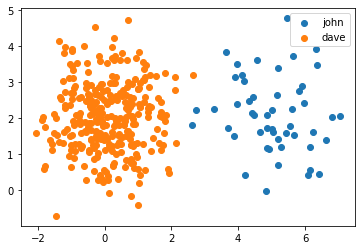

In [111]:
# Your code here
plt.scatter(data_john[:,0],data_john[:,1], label ='john')
plt.scatter(data_dave[:,0],data_dave[:,1], label ='dave')
plt.legend()

6. (2pts) Plan your strategy. What did you see? What are you going to do? Why?

##### Your explanation Here
As shown above, it is clear to see the imbalance between the two data collections where one of John's contains the relatively smaller amount of data than that one Dave's

As for the strategy tackling such classification problem, i go for a model using randomforest method, since random forest has an effective method for estimating missing data and maintains the accuracy  when large proportion of the data are missing.
It has methods for balancing errors in data set where classes arre imbalanced 

So, as for my tree_params, i added 'class_weight' : {0,1/7,1:6/7} as for the data collected by dave is 350 datapoints and one by John is 50 data points

7. (4pts) Develop a model.

In [125]:
# Your code here
import random, math
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score

class RandomForest:
    def __init__(self, B, bootstrap_ratio, with_no_replacement=True):
        self.B = B
        self.bootstrap_ratio = bootstrap_ratio
        self.with_no_replacement = with_no_replacement
        ######### max_features = 'sqrt'
        self.tree_params = {'max_depth': 2, 'max_features': 'sqrt','class_weight' : {0:1/7, 1:6/7}}
        self.models = [DecisionTreeClassifier(**self.tree_params) for _ in range(B)]
                
    def fit(self, X, y):  #<---X_train, y_train
        m, n = X.shape

        #sample size for each tree
        sample_size = int(self.bootstrap_ratio * len(X))

        xsamples = np.zeros((B, sample_size, n))
        ysamples = np.zeros((B, sample_size))

        xsamples_oob = []  #use list because length is not known
        ysamples_oob = []

        #bootstrapping samples for each model
        for i in range(self.B):
            oob_idx = []
            idxes = []
            for j in range(sample_size):
                idx = random.randrange(m)
                if (self.with_no_replacement):
                    while idx in idxes:
                        idx = random.randrange(m)
                idxes.append(idx)
                oob_idx.append(idx)
                xsamples[i, j, :] = X[idx]
                ysamples[i, j] = y[idx]
            mask = np.zeros((m), dtype=bool)
            mask[oob_idx] = True
            xsamples_oob.append(X[~mask])
            ysamples_oob.append(y[~mask])
    
        #fitting each estimator
        oob_score = 0
        print("======Out of bag score for each tree======")
        for i, model in enumerate(self.models):
            
            _X = xsamples[i]
            _y = ysamples[i]
            model.fit(_X, _y)

            #calculating oob score
            _X_test = np.asarray(xsamples_oob[i])
            _y_test = np.asarray(ysamples_oob[i])
            yhat = model.predict(_X_test)
            oob_score += accuracy_score(_y_test, yhat)
            print(f"Tree {i}", accuracy_score(_y_test, yhat))
        self.avg_oob_score = oob_score / len(self.models)
        print("======Average out of bag score======")
        print(self.avg_oob_score)
    
    def predict(self, X): #<---X_test
        #make prediction and return the probabilities
        predictions = np.zeros((self.B, X.shape[0]))
        for i, model in enumerate(self.models):
            yhat = model.predict(X)
            predictions[i, :] = yhat
        return stats.mode(predictions)[0][0]

In [126]:
data = np.concatenate((data_john,data_dave),axis = 0)
print(data.shape)
X = data[:,:2]
y = data[:,2]
print(X.shape)
print(y.shape)

(350, 3)
(350, 2)
(350,)


In [127]:
# X, y = make_blobs(n_samples=3000, centers=4,random_state=40, cluster_std=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, shuffle=True, random_state=42)

print('======= Train =======')
print(X_train.shape,y_train.shape)
print('======= Test =======')
print(X_test.shape,y_test.shape)

======= Train =======
(245, 2) (245,)
======= Test =======
(105, 2) (105,)


In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [129]:
B= 5
model = RandomForest(B=5, bootstrap_ratio=0.8)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

======Out of bag score for each tree======
Tree 0 0.9591836734693877
Tree 1 0.9795918367346939
Tree 2 0.8571428571428571
Tree 3 1.0
Tree 4 0.7959183673469388
======Average out of bag score======
0.9183673469387754


8. (1pt) Show report.

In [130]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        89

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



9. (2pts) Is the result good. If not, Why?

Well, it seems like a good model. Each of the 5 trees result in high accuracy.

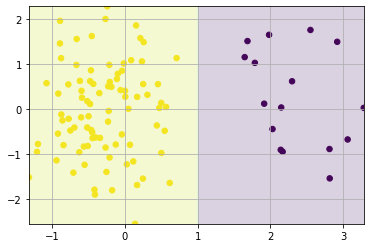

In [131]:
def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=200),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=200))
#     print(xx.shape,yy.shape)
#     print(X[:, 0].shape, X[:, 1].shape)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#     print(Z.shape)
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)

# plot_tree(bag, X_train[:,:2], y_train)    
    
########### only 2 featuresssssssss
plot_tree(model, X_test[:,:2], y_test)